### 

# INF01017 - Aprendizado de Máquina - 2023/2

## Trabalho 1 - Aprendizado Supervisionado - Grupo 10

#### Eduardo Fantini
#### João Pedro Silveira e Silva
#### José Henrique Lima Marques
#### Matheus Almeida Silva
---

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from typing import NamedTuple
import matplotlib.pyplot as plt
from itertools import chain
from math import ceil

## Leitura do Dataset

Link para o dataset

In [3]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### Separando a feature "HeartDisease" do resto (target)

In [4]:
target = df['HeartDisease']
df = df.drop('HeartDisease', axis=1)

### Identificando features categóricas e numéricas

In [5]:
features = df.columns

categorical_features = []
numerical_features = []

for feature in features:
    amount_of_unique_values = len(df[feature].unique())
    feature_type = df[feature].dtype
    print(f'Feature  | {feature :^16} | {str(feature_type): ^7}|{amount_of_unique_values : ^3} unique values|', end="")
    if feature_type in [np.int64, np.float64] and amount_of_unique_values > 2:
        numerical_features.append(feature)
        print('Numerical.')
    else:
        categorical_features.append(feature)
        print('Categorical.')

print('\n\nTotal number of features:\n--------------------')
print(f'{len(categorical_features)} categorical_features.')
print(f'{len(numerical_features)} numerical_features.')

Feature  |       Age        |  int64 |50  unique values|Numerical.
Feature  |       Sex        | object | 2  unique values|Categorical.
Feature  |  ChestPainType   | object | 4  unique values|Categorical.
Feature  |    RestingBP     |  int64 |67  unique values|Numerical.
Feature  |   Cholesterol    |  int64 |222 unique values|Numerical.
Feature  |    FastingBS     |  int64 | 2  unique values|Categorical.
Feature  |    RestingECG    | object | 3  unique values|Categorical.
Feature  |      MaxHR       |  int64 |119 unique values|Numerical.
Feature  |  ExerciseAngina  | object | 2  unique values|Categorical.
Feature  |     Oldpeak      | float64|53  unique values|Numerical.
Feature  |     ST_Slope     | object | 3  unique values|Categorical.


Total number of features:
--------------------
6 categorical_features.
5 numerical_features.


### Criando um dataframe específico para cada tipo de feature

In [6]:
cat_df = df[categorical_features]
num_df = df[numerical_features]

### Dataframe de features categóricas:

In [7]:
cat_df

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,0,Normal,N,Up
1,F,NAP,0,Normal,N,Flat
2,M,ATA,0,ST,N,Up
3,F,ASY,0,Normal,Y,Flat
4,M,NAP,0,Normal,N,Up
...,...,...,...,...,...,...
913,M,TA,0,Normal,N,Flat
914,M,ASY,1,Normal,N,Flat
915,M,ASY,0,Normal,Y,Flat
916,F,ATA,0,LVH,N,Flat


### Dataframe de features numéricas:

In [8]:
num_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,40,140,289,172,0.0
1,49,160,180,156,1.0
2,37,130,283,98,0.0
3,48,138,214,108,1.5
4,54,150,195,122,0.0
...,...,...,...,...,...
913,45,110,264,132,1.2
914,68,144,193,141,3.4
915,57,130,131,115,1.2
916,57,130,236,174,0.0


### Normalização

Normalização dos dados de entrada e criação dos feature vectors utilizados para treino. Dados numéricos são normalizados com L2 e dados categóricos viram labels binárias.

In [9]:
# Normalização dos valores categóricos
normalized_categorical_feats = [preprocessing.label_binarize(df[l], classes=df[l].unique()) for l in categorical_features]
normalized_categorical_feats_array = np.hstack(normalized_categorical_feats)

# Normalização dos valores numéricos
normalized_numerical_feats = [preprocessing.normalize([df[l]]) for l in numerical_features]
normalized_numerical_feats_array = np.vstack(normalized_numerical_feats).T

# Linhas de features normalizados
normalized_feature_vectors = np.hstack([normalized_categorical_feats_array, normalized_numerical_feats_array])

normalized_feature_vectors


array([[0.        , 1.        , 0.        , ..., 0.04204228, 0.0407949 ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.0261855 , 0.03700003,
        0.02379604],
       [0.        , 1.        , 0.        , ..., 0.04116943, 0.02324361,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01905723, 0.02727566,
        0.02855525],
       [1.        , 1.        , 0.        , ..., 0.0343321 , 0.04126926,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.02545813, 0.04103208,
        0.        ]])

## Cálculo de pontuações

Calcula as pontuações de um estimador para valores de K diferentes

In [10]:
class EstimatorPreds(NamedTuple):
    preds_and_targets_k : any
    confusion_matrices_by_k : any

def predictKFolds(estimator, X, Y, K_values):
    predictions = []

    # Avalia para diferentes valores de K
    for k in K_values:
        # Matrizes de confusão para cada fold
        confusion_matrices_k = []
        # Predições e valores corretos
        preds_and_targets_k = []

        k_fold = KFold(n_splits=k)
        for train_index,test_index in k_fold.split(X):
            # Obtém dados para este fold
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
            # Fitting
            estimator.fit(X_train, y_train)
            # Predição
            y_pred = estimator.predict(X_test)

            preds_and_targets_k.append((y_pred, y_test))
            confusion_matrices_k.append(confusion_matrix(y_pred, y_test))


        predictions.append(EstimatorPreds(preds_and_targets_k, confusion_matrices_k))

    return predictions

In [12]:
K_values = [2, 5, 7, 10]
X_data = normalized_feature_vectors
Y_data = target

def printEvaluation(model_name, predictions):
    evaluations = [
        ('Accuracy', metrics.accuracy_score),
        ('Recall', metrics.recall_score),
        ('Precision', metrics.precision_score)
    ]
    
    print(f'Results for {model_name}:')
    print('-----------------------------------------------------------------')
    for prediction_k in predictions:
        k = len(prediction_k.preds_and_targets_k)
        print(f'K = {k : <2}:')
        for score_name, score_fn in evaluations:
            scores = []
            for pred, target in prediction_k.preds_and_targets_k:
                scores.append(score_fn(pred, target))
            print(f'{score_name :<12}: Mean = {np.mean(scores):.16f}, Std = {np.std(scores) :.16f}')
        
        print('-----------------------------------------------------------------')
        print('Confusion Matrices:')
        fig, axs = plt.subplots(max(3, ceil(k / 3)), 3)
        fig.tight_layout(pad=2.0)
        axs = list(chain.from_iterable(axs))

        for ax in axs: ax.set_axis_off()
        for i, matrix in enumerate(prediction_k.confusion_matrices_by_k):
            disp = ConfusionMatrixDisplay(matrix)
            disp.plot(ax=axs[i], colorbar=False)
            axs[i].set_axis_on()
        
        plt.plot
        plt.show()



## Árvore de decisão

Results for Decision Tree:
-----------------------------------------------------------------
K = 2 :
Accuracy    : Mean = 0.7374727668845316, Std = 0.0468409586056645
Recall      : Mean = 0.7783333333333333, Std = 0.0272222222222223
Precision   : Mean = 0.7325583197705960, Std = 0.0698132217313803
-----------------------------------------------------------------
Confusion Matrices:


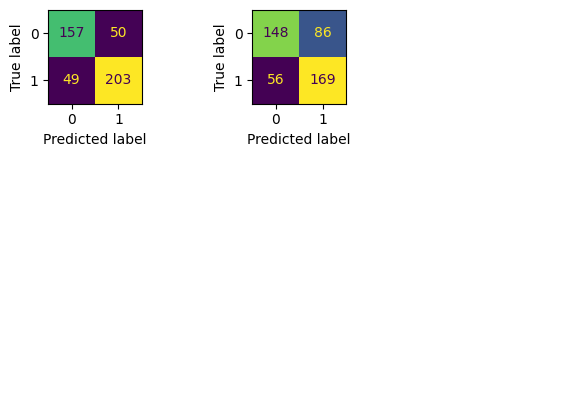

K = 5 :
Accuracy    : Mean = 0.7634948918983132, Std = 0.0553546437373618
Recall      : Mean = 0.7813025221031665, Std = 0.0939770055832358
Precision   : Mean = 0.7642934564454521, Std = 0.0647049379248422
-----------------------------------------------------------------
Confusion Matrices:


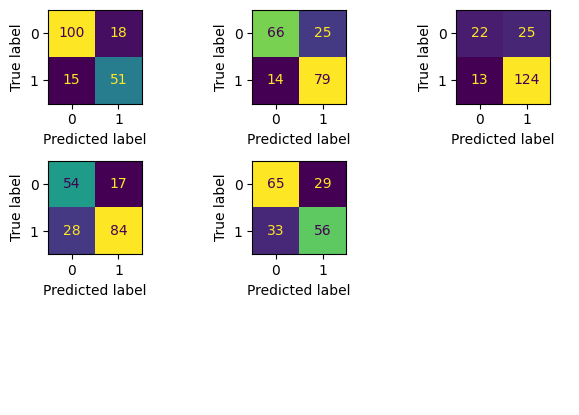

K = 7 :
Accuracy    : Mean = 0.7788490135818379, Std = 0.0469551236254704
Recall      : Mean = 0.7956133850608087, Std = 0.0786756612055839
Precision   : Mean = 0.7775750484544036, Std = 0.0581170094588347
-----------------------------------------------------------------
Confusion Matrices:


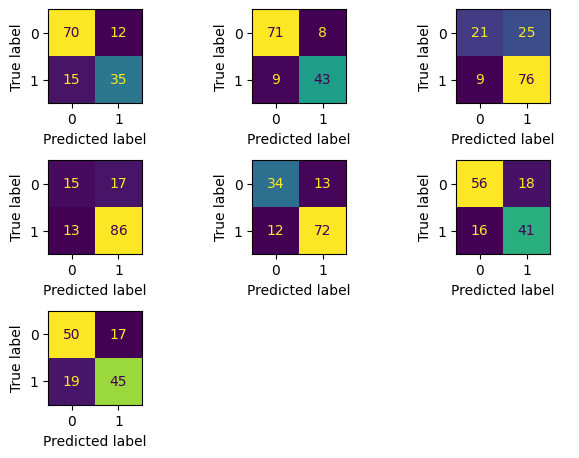

K = 10:
Accuracy    : Mean = 0.7732799808886766, Std = 0.0609458270255413
Recall      : Mean = 0.7948279628721563, Std = 0.0997840904733846
Precision   : Mean = 0.7663433045063922, Std = 0.0839185519237184
-----------------------------------------------------------------
Confusion Matrices:


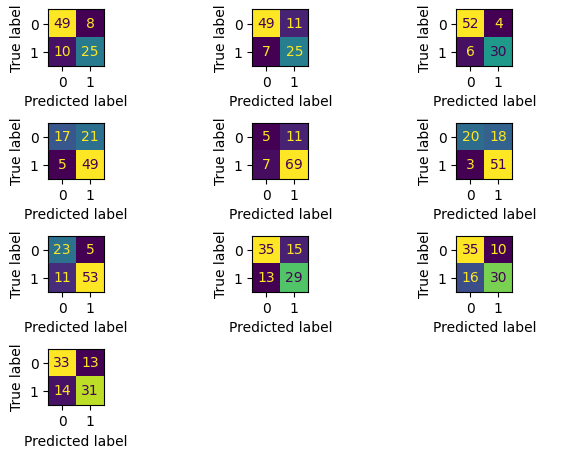

In [13]:
decisionTree = DecisionTreeClassifier()
predictions_tree = predictKFolds(decisionTree, X_data, Y_data, K_values)
printEvaluation('Decision Tree', predictions_tree)

## Rede Neural

Results for Neural Network (Ix100x100x50xO):
-----------------------------------------------------------------
K = 2 :
Accuracy    : Mean = 0.8442265795206971, Std = 0.0577342047930283
Recall      : Mean = 0.8242189458903766, Std = 0.0525926483125219
Precision   : Mean = 0.9155157715260017, Std = 0.0410059676044331
-----------------------------------------------------------------
Confusion Matrices:


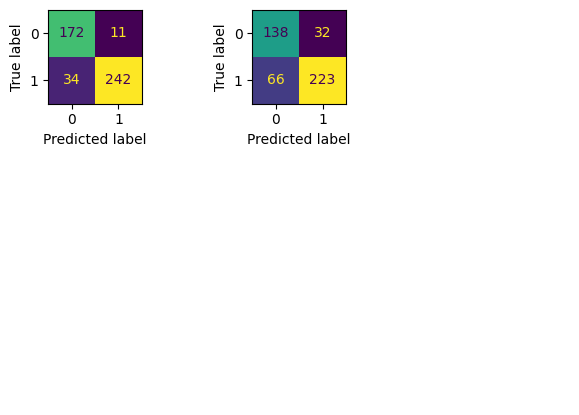

K = 5 :
Accuracy    : Mean = 0.8495367070563079, Std = 0.0529701768926078
Recall      : Mean = 0.8230156969094946, Std = 0.0750657920904248
Precision   : Mean = 0.9038306665448097, Std = 0.0666631913917643
-----------------------------------------------------------------
Confusion Matrices:


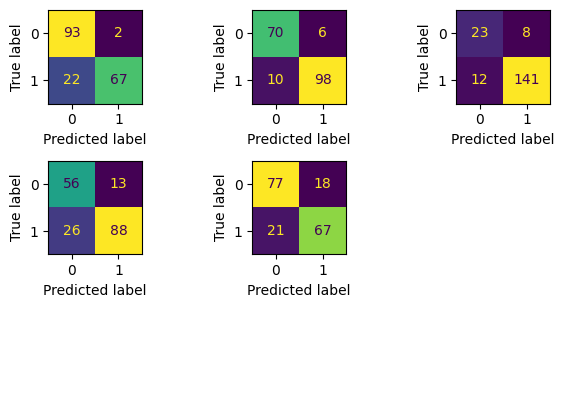

K = 7 :
Accuracy    : Mean = 0.8288969300419682, Std = 0.0631844339740809
Recall      : Mean = 0.8201052001095607, Std = 0.0887003418174628
Precision   : Mean = 0.8773138437569505, Std = 0.0599364249143857
-----------------------------------------------------------------
Confusion Matrices:


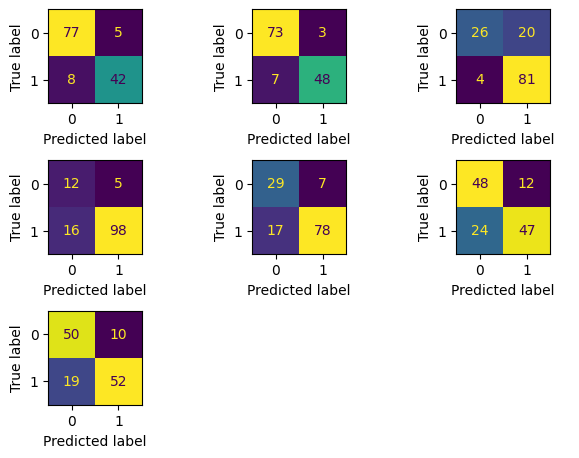

K = 10:
Accuracy    : Mean = 0.8538939321548018, Std = 0.0625659825003295
Recall      : Mean = 0.8342123784193103, Std = 0.0809014322691583
Precision   : Mean = 0.8976998098544311, Std = 0.0820290567562982
-----------------------------------------------------------------
Confusion Matrices:


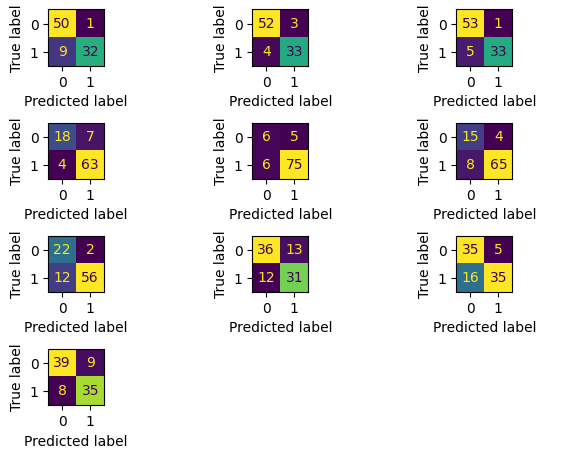

In [14]:
neuralNet = MLPClassifier([100,100,50], early_stopping=True)
predictions_net = predictKFolds(neuralNet, X_data, Y_data, K_values)
printEvaluation('Neural Network (Ix100x100x50xO)', predictions_net)

## K Nearest Neighbours

Results for 7 Nearest Neighbors:
-----------------------------------------------------------------
K = 2 :
Accuracy    : Mean = 0.8180827886710240, Std = 0.0294117647058823
Recall      : Mean = 0.8288210248128028, Std = 0.0446483629422992
Precision   : Mean = 0.8503758815779277, Std = 0.0045260792063861
-----------------------------------------------------------------
Confusion Matrices:


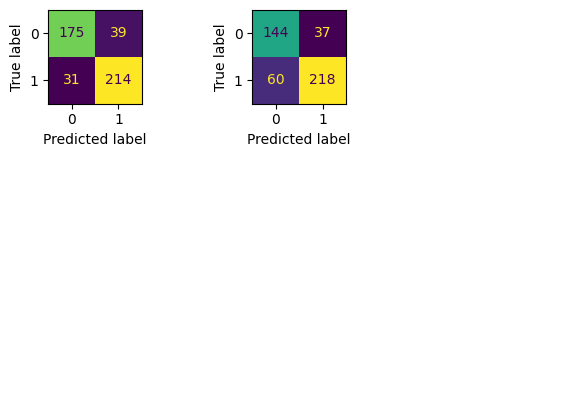

K = 5 :
Accuracy    : Mean = 0.8408648134948919, Std = 0.0424716706452381
Recall      : Mean = 0.8449060633977027, Std = 0.0650991572830553
Precision   : Mean = 0.8620731479736852, Std = 0.0430359824061024
-----------------------------------------------------------------
Confusion Matrices:


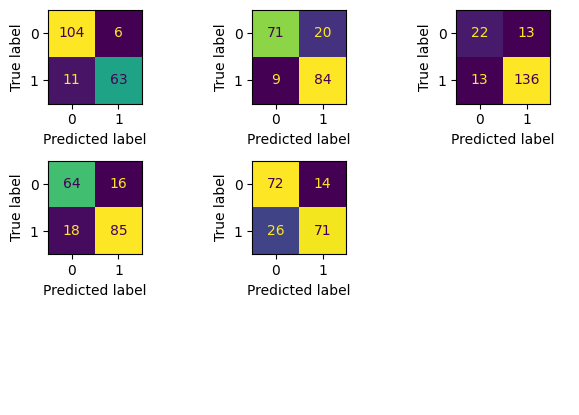

K = 7 :
Accuracy    : Mean = 0.8408925679918047, Std = 0.0516457750956760
Recall      : Mean = 0.8395600410204470, Std = 0.0677474947701818
Precision   : Mean = 0.8678622772758517, Std = 0.0666685146681640
-----------------------------------------------------------------
Confusion Matrices:


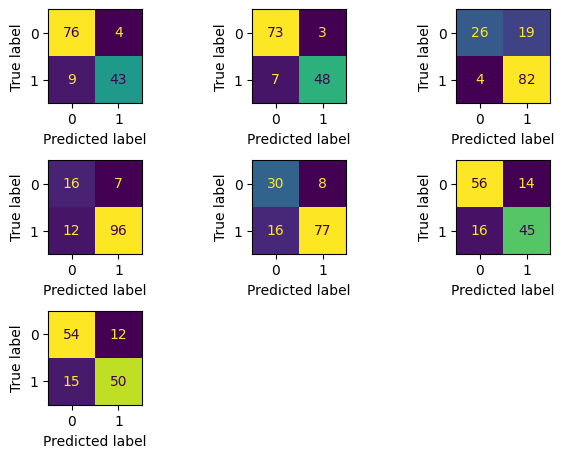

K = 10:
Accuracy    : Mean = 0.8452102245580507, Std = 0.0621729514943687
Recall      : Mean = 0.8405467806365184, Std = 0.0721886144770978
Precision   : Mean = 0.8816382211873437, Std = 0.0855567614868867
-----------------------------------------------------------------
Confusion Matrices:


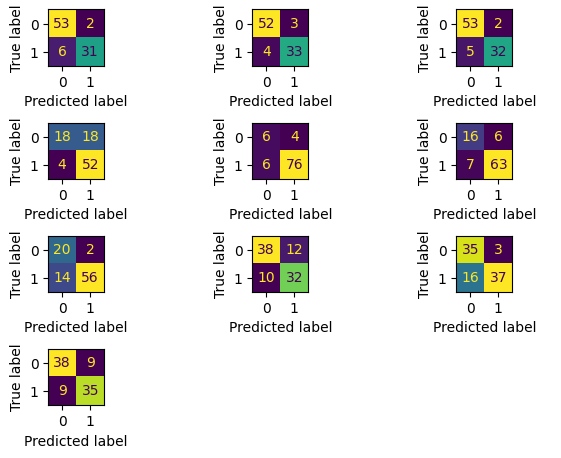

In [15]:
neigh7 = KNeighborsClassifier(n_neighbors=7)
predictions_neigh7 = predictKFolds(neigh7, X_data, Y_data, K_values)
printEvaluation('7 Nearest Neighbors', predictions_neigh7)

## Gaussian Naive Bayes

Results for Gaussian Naive Bayes:
-----------------------------------------------------------------
K = 2 :
Accuracy    : Mean = 0.8224400871459695, Std = 0.0381263616557734
Recall      : Mean = 0.8336313129820621, Std = 0.0489597801353468
Precision   : Mean = 0.8523986669766721, Std = 0.0092614120747113
-----------------------------------------------------------------
Confusion Matrices:


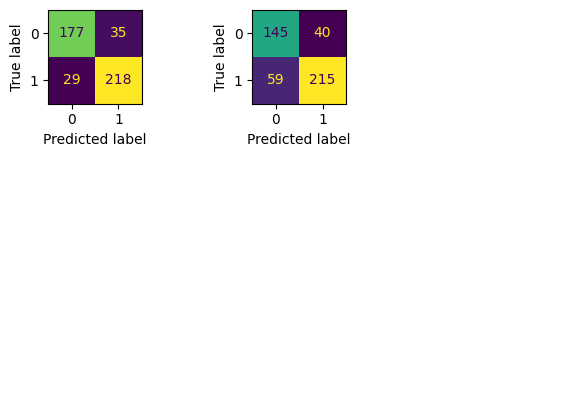

K = 5 :
Accuracy    : Mean = 0.8473330957472083, Std = 0.0614085670329350
Recall      : Mean = 0.8434915717906424, Std = 0.0652721368233218
Precision   : Mean = 0.8570553781641653, Std = 0.0818156238520110
-----------------------------------------------------------------
Confusion Matrices:


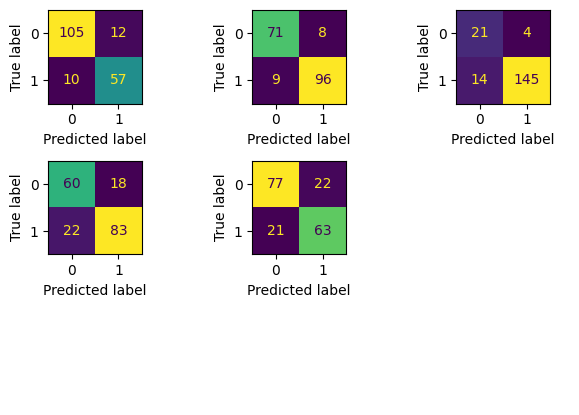

K = 7 :
Accuracy    : Mean = 0.8496497141535310, Std = 0.0535239892212559
Recall      : Mean = 0.8439906571517710, Std = 0.0604493953445528
Precision   : Mean = 0.8514764376282326, Std = 0.0984235985376164
-----------------------------------------------------------------
Confusion Matrices:


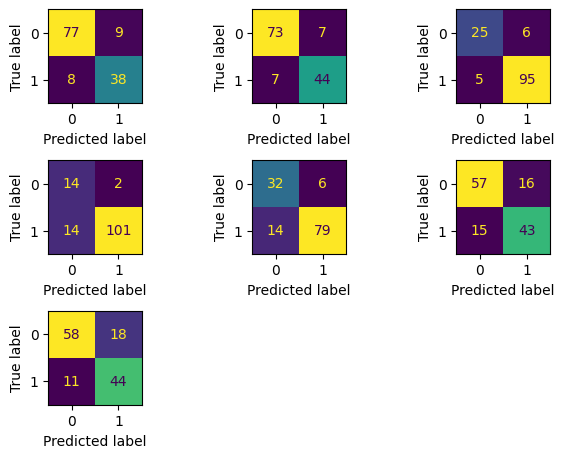

K = 10:
Accuracy    : Mean = 0.8549689440993788, Std = 0.0616821896812226
Recall      : Mean = 0.8543109792248123, Std = 0.0682564877023740
Precision   : Mean = 0.8536790991440872, Std = 0.1072511359491464
-----------------------------------------------------------------
Confusion Matrices:


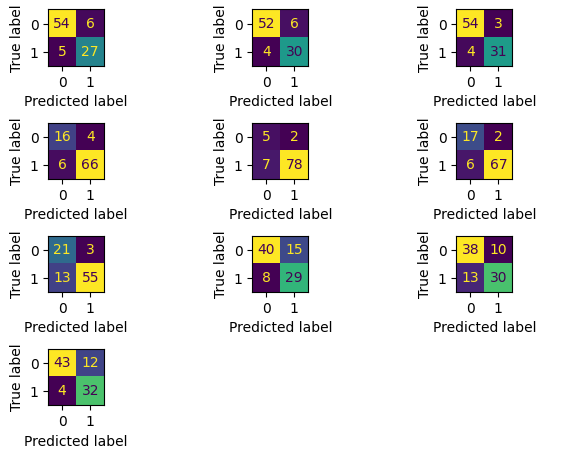

In [16]:
gaussian = GaussianNB()
predictions_gaussian = predictKFolds(gaussian, X_data, Y_data, K_values)
printEvaluation('Gaussian Naive Bayes', predictions_gaussian)

## Ensemble

Results for Ensemble:
-----------------------------------------------------------------
K = 2 :
Accuracy    : Mean = 0.8191721132897604, Std = 0.0392156862745098
Recall      : Mean = 0.8343225419664269, Std = 0.0573441247002398
Precision   : Mean = 0.8464543129504767, Std = 0.0006045105789351
-----------------------------------------------------------------
Confusion Matrices:


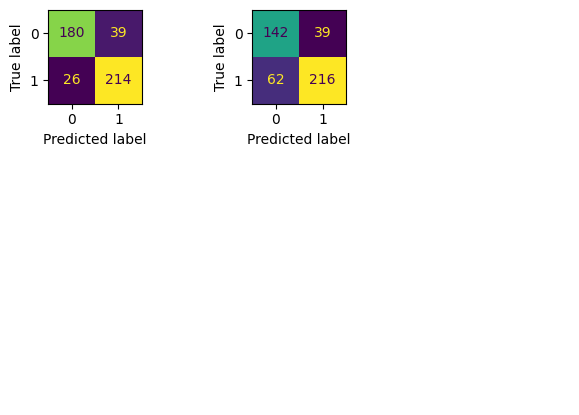

K = 5 :
Accuracy    : Mean = 0.8528035162746495, Std = 0.0541227782841203
Recall      : Mean = 0.8443674597573680, Std = 0.0713138699200727
Precision   : Mean = 0.8801602179595619, Std = 0.0474083021113832
-----------------------------------------------------------------
Confusion Matrices:


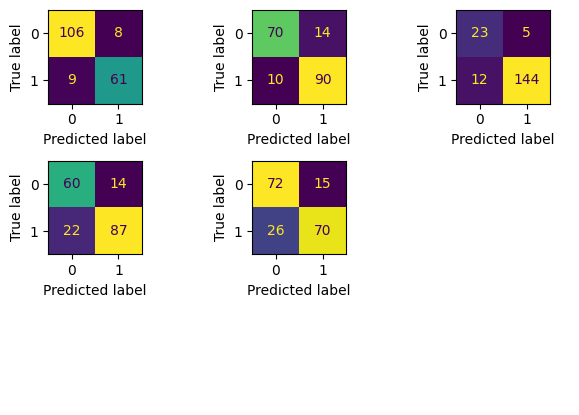

K = 7 :
Accuracy    : Mean = 0.8485178943194212, Std = 0.0585844771966085
Recall      : Mean = 0.8437595807893066, Std = 0.0712472482651098
Precision   : Mean = 0.8708943003783899, Std = 0.0817802342808462
-----------------------------------------------------------------
Confusion Matrices:


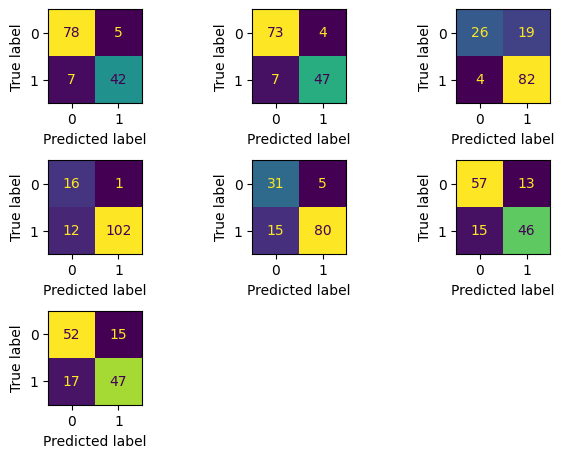

K = 10:
Accuracy    : Mean = 0.8516841853798376, Std = 0.0660490631188734
Recall      : Mean = 0.8460154540589324, Std = 0.0738843349861500
Precision   : Mean = 0.8703066467148396, Std = 0.1007954713384026
-----------------------------------------------------------------
Confusion Matrices:


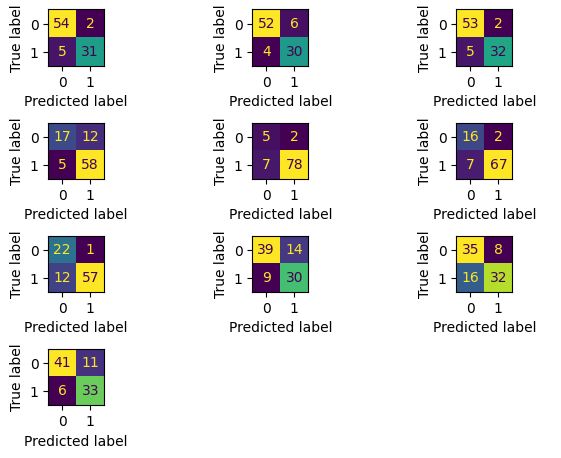

In [17]:
estimators = [('naive_bayes', GaussianNB()), ('knn5', KNeighborsClassifier(n_neighbors=5)), ('random_forest', RandomForestClassifier())]

stacking_classifier = StackingClassifier(estimators=estimators)

predictions_stacking = predictKFolds(stacking_classifier, X_data, Y_data, K_values)
printEvaluation('Ensemble', predictions_stacking)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6feaeef6-08d6-4074-9393-4c06f6e32006' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>